In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import gget
import tabulate
from sklearn.neighbors import BallTree
from scipy.stats import gmean


# locals
import utils as ut


In [2]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath)
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [3]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64



,spotId,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells,key
0,AAACAAGTATCTCCCA.1,0.087213,0.113186,0.270488,0.096431,0.057255,0.083130,0.047384,0.163491,0.049659,0.006606,0.025157,HFD8
1,AAACACCAATAACTGC.1,0.159247,0.129071,0.105884,0.002606,0.084753,0.088446,0.016601,0.302068,0.046115,0.038813,0.026395,HFD8
2,AAACAGCTTTCAGAAG.1,0.042437,0.128286,0.329050,0.064440,0.050805,0.049080,0.052493,0.100578,0.065773,0.025274,0.091783,HFD8
3,AAACAGGGTCTATATT.1,0.038153,0.094966,0.294255,0.055503,0.061959,0.060107,0.048176,0.127678,0.099188,0.040547,0.079468,HFD8
4,AAACAGTGTTCCTGGG.1,0.000020,0.256841,0.323585,0.003329,0.015668,0.010229,0.002518,0.222850,0.000587,0.000737,0.163636,HFD8


In [4]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


In [5]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(14848, 4)
HFD8     6788
ND       4072
HFD14    3988
Name: key, dtype: int64



,spotId,x,y,key
0,AAACATTTCCCGGATT.1,1139.783401,1365.804581,HFD14
1,AAACCGGGTAGGTACC.1,468.056902,1045.415505,HFD14
2,AAACCGTTCGTCCAGG.1,604.524374,1214.452428,HFD14
3,AAACCTAAGCAGCCGG.1,1003.708924,1433.743571,HFD14
4,AAACCTCATGAAGTTG.1,380.369919,960.970730,HFD14


In [6]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

HFD8     3394
ND       2036
HFD14    1994
Name: key, dtype: int64


,spotId,x,y,key,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells
0,AAACATTTCCCGGATT.1,1139.783401,1365.804581,HFD14,3.468007e-02,0.007548,0.409201,0.170860,0.004757,0.041542,0.055275,0.219997,0.010912,0.004188,0.041040
2,AAACCGGGTAGGTACC.1,468.056902,1045.415505,HFD14,1.280364e-03,0.088368,0.187514,0.019633,0.028867,0.129969,0.040070,0.450618,0.008903,0.013757,0.031021
4,AAACCGTTCGTCCAGG.1,604.524374,1214.452428,HFD14,3.752028e-04,0.004256,0.283055,0.187004,0.021560,0.108340,0.044845,0.310869,0.003200,0.004016,0.032480
6,AAACCTAAGCAGCCGG.1,1003.708924,1433.743571,HFD14,1.198581e-07,0.009084,0.239973,0.043516,0.004948,0.057287,0.052469,0.558332,0.000064,0.023214,0.011113
8,AAACCTCATGAAGTTG.1,380.369919,960.970730,HFD14,1.377525e-02,0.029749,0.216199,0.122802,0.053188,0.158933,0.041466,0.234411,0.043126,0.037127,0.049224


In [7]:
# break

ND mean: 110.2 median: 91.0
HFD8 mean: 158.8 median: 105.0
HFD14 mean: 232.7 median: 173.0


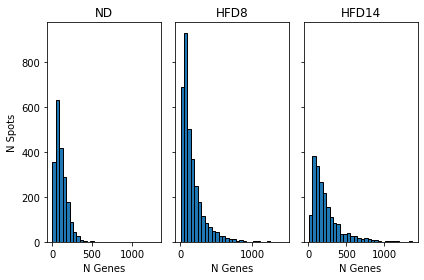

In [8]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 9, 3

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

for i, key in enumerate(keys):
    sdf = spt[key]
    
    bdf = sdf.astype(bool)
    rowSums = bdf.sum(axis=1)
    
    print(f"{key} mean: {rowSums.mean():.1f} median: {rowSums.median():.1f}")
    
    axs[i].hist(rowSums, 
                edgecolor='k', 
                bins=30)

    axs[i].set_xlabel("N Genes")
    if i == 0:
        axs[i].set_ylabel("N Spots")
    else:
        axs[i].set_ylabel("")
    axs[i].set_title(key)
    
    # break
    
plt.tight_layout()
    

In [9]:
keys = ['ND', 'HFD8', 'HFD14']

lrData = {}

for key in keys:
    sdf = spt[key]
    newCols = {}
    
    for idx, row in lr.iterrows():
        l = row['ligand']
        r = row['receptor']
        
        if l in sdf.columns and r in sdf.columns:
            gMean = gmean(sdf[[l, r]], axis=1)
            lrName = row['Pair.Name']
            newCols[lrName] = gMean
    
    lrdf = pd.DataFrame(newCols)
    lrdf.index = sdf.index
    
    # remove zero-sum columns 
    lrdf = lrdf.loc[:, (lrdf.sum(axis=0) != 0)]
    print(sdf.shape, lrdf.shape)
    
    lrData[key] = lrdf


print('done')

(2036, 31053) (2036, 124)
(3394, 31053) (3394, 253)
(1994, 31053) (1994, 270)
done


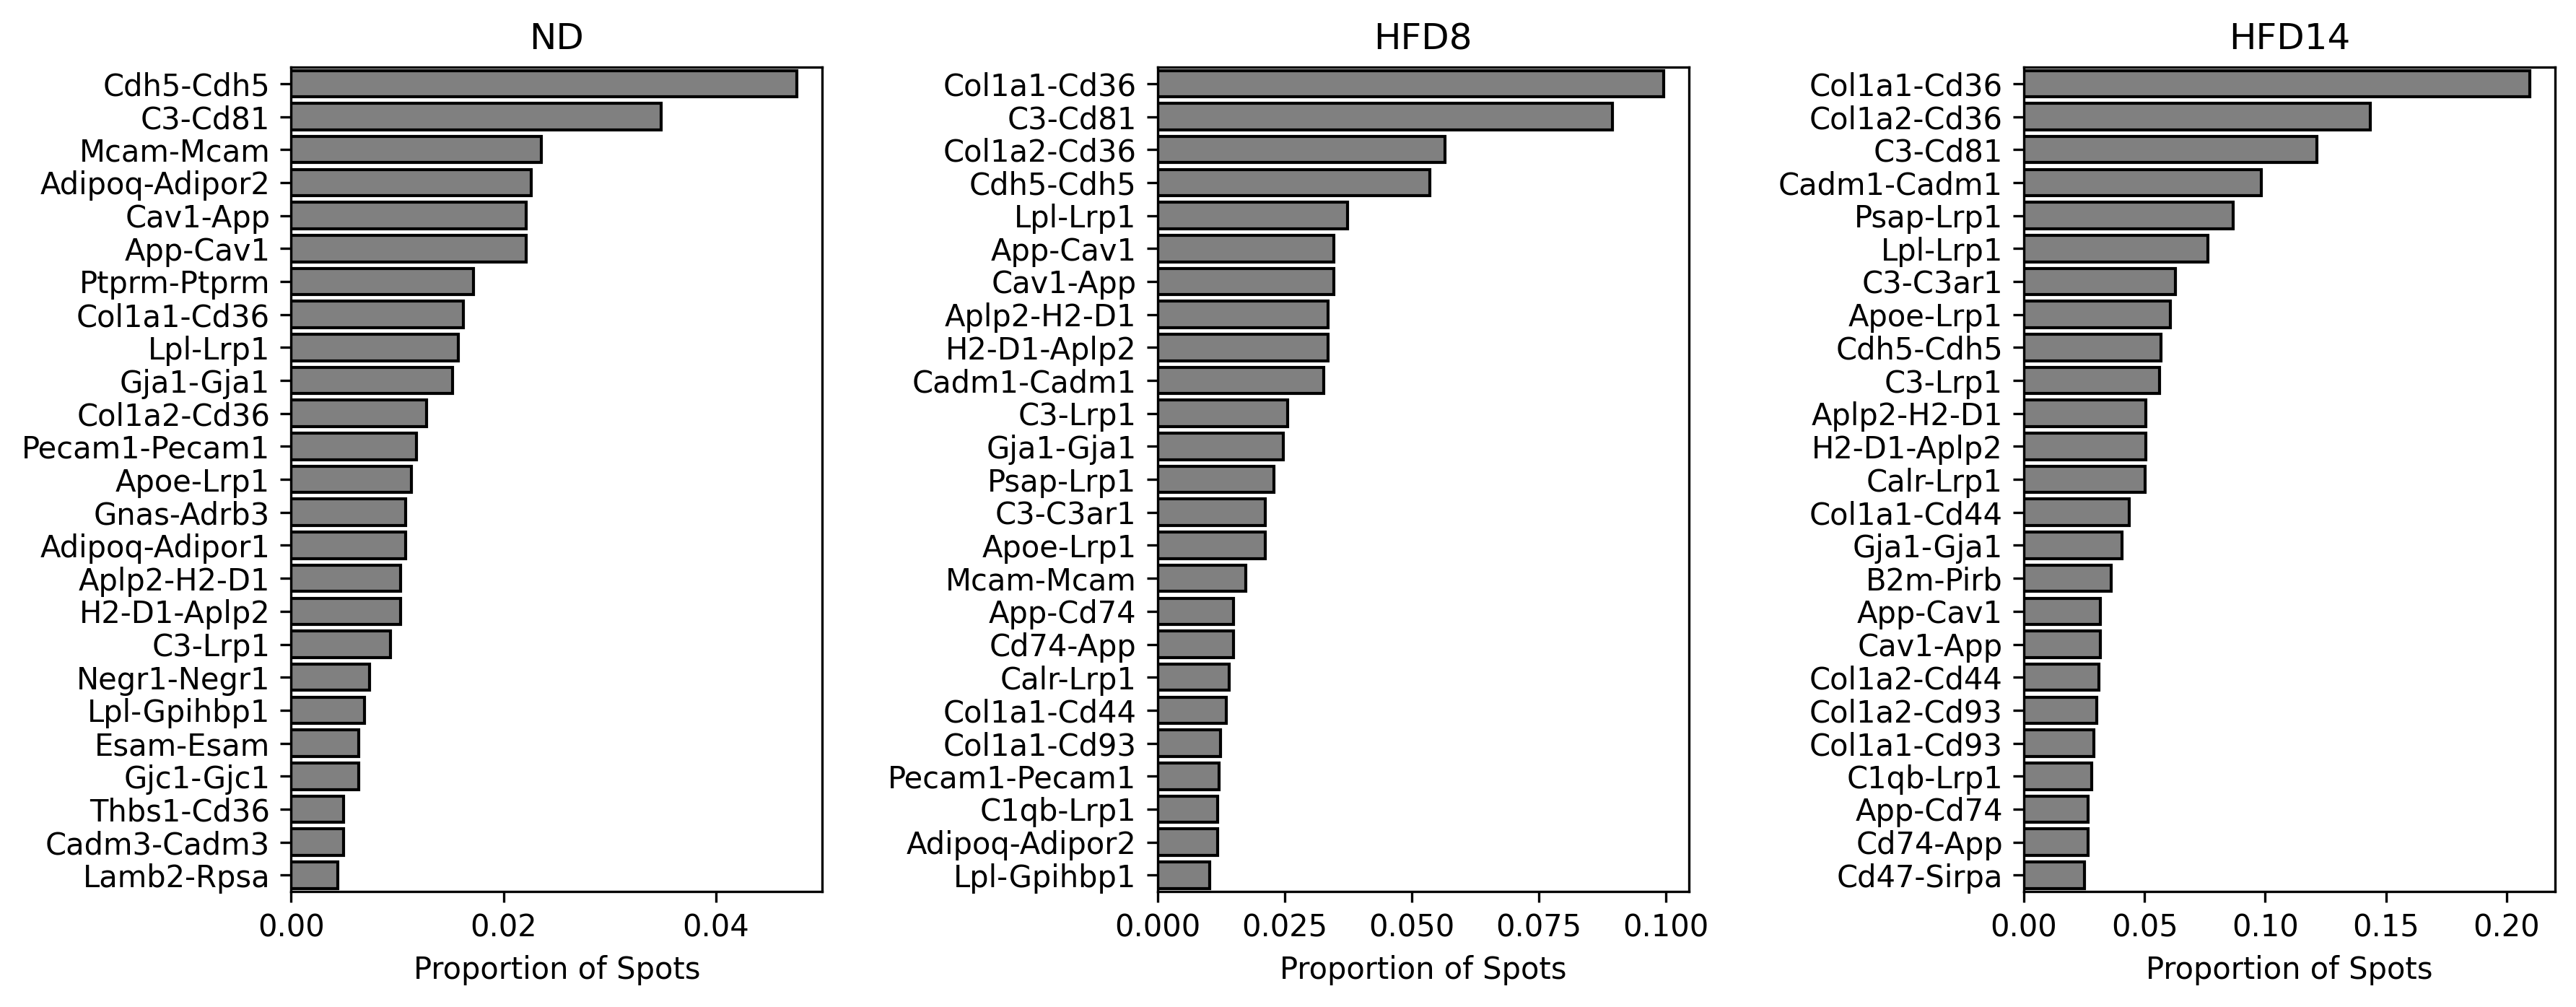

In [10]:
n = 25

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 4.75

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, key in enumerate(keys):
    ldf = lrData[key]
    ldfBool = ldf.astype(bool) 
    colSumns = ldfBool.sum(axis=0)
    prop = colSumns / len(ldfBool)
    prop = pd.DataFrame(prop)
    prop = prop.reset_index(drop=False)
    prop.columns = ['LR', 'Proportion']
    prop = prop.sort_values(by='Proportion', ascending=False)
    # print(f"==== {key} ====")
    # print(prop.head(n))
    
    sns.barplot(data=prop.head(n),
                y='LR', 
                x='Proportion', 
                color='grey',
                edgecolor='k',
                ax=axs[i])
    
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("Proportion of Spots")
    axs[i].set_title(key)
    
plt.tight_layout()


In [11]:
def printGSR(ef, top=None, columns=['path_name', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

# 'plain', 'simple', 'grid', 'pipe', 'orgtbl', 'rst', 'mediawiki',
# 'latex', 'latex_raw', 'latex_booktabs', 'latex_longtable' and tsv.
# Variable `tabulate_formats`contains the list of currently supported formats.

In [12]:
alpha = 0.05
top = 10
db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
# db = 'ontology'


def flatten(l):
    return [item for sublist in l for item in sublist]

# look at the top ligand-receptors
for i, key in enumerate(keys):
    ldf = lrData[key]
    ldfBool = ldf.astype(bool) 
    colSumns = ldfBool.sum(axis=0)
    prop = colSumns / len(ldfBool)
    prop = pd.DataFrame(prop)
    prop = prop.reset_index(drop=False)
    prop.columns = ['LR', 'Proportion']
    prop = prop.sort_values(by='Proportion', ascending=False)
    
    pairs = prop['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    ef = gget.enrichr(genes, database=db)
    ef = ef[ef['p_val'] <= alpha]
    pd.set_option('display.max_colwidth', 200)
    
    print(f"==== {key} ====")
    printGSR(ef, top=10)
    print()
    print(pairs)
    print()
    
    # break

Thu Jan 19 12:35:56 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Thu Jan 19 12:35:56 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


==== ND ====
| path_name                                      | overlapping_genes   |
|------------------------------------------------+---------------------|
| Alzheimers Disease WP2075                      | APP, LRP1, LPL      |
| Leptin and adiponectin WP683                   | ADIPOQ, ADIPOR2     |
| PPAR signaling pathway WP2316                  | ADIPOQ, LPL, CD36   |
| Statin Pathway WP1                             | LRP1, LPL           |
| Retinol metabolism WP1259                      | LPL, CD36           |
| Adipogenesis genes WP447                       | ADIPOQ, LPL         |
| EGFR1 Signaling Pathway WP572                  | GJA1, CAV1          |
| Osteoblast WP238                               | COL1A1              |
| Focal Adhesion WP85                            | COL1A1, CAV1        |
| Complement Activation, Classical Pathway WP200 | C3                  |

['Cdh5-Cdh5', 'C3-Cd81', 'Mcam-Mcam', 'Adipoq-Adipor2', 'Cav1-App', 'App-Cav1', 'Ptprm-Ptprm', 'Col1a1-Cd36', 

Thu Jan 19 12:35:57 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


==== HFD8 ====
| path_name                                                         | overlapping_genes    |
|-------------------------------------------------------------------+----------------------|
| Alzheimers Disease WP2075                                         | APP, LRP1, LPL       |
| Statin Pathway WP1                                                | LRP1, LPL            |
| Dysregulated miRNA Targeting in Insulin/PI3K-AKT Signaling WP3855 | COL1A1, COL1A2       |
| Inflammatory Response Pathway WP458                               | COL1A1, COL1A2       |
| Focal Adhesion WP85                                               | COL1A1, COL1A2, CAV1 |
| Retinol metabolism WP1259                                         | LPL, CD36            |
| Splicing factor NOVA regulated synaptic proteins WP1983           | CADM1, APLP2         |
| PPAR signaling pathway WP2316                                     | LPL, CD36            |
| Osteoblast WP238                                     

In [13]:
queryPairs = [
   'Dcn-Egfr',
]

cTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
    'T cells',
    'NK cells', 
    'Dendritic cells', 
    'Stromal cells', 
    'B cells'
]

layer = 1

for key in keys:
    ldf = lrData[key][queryPairs].reset_index(drop=False)
    ldf = ldf.rename(columns={'index':'spotId'})
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    cdf['cType'] = cdf[cTypes].apply(lambda x: cTypes[np.argsort(x)[-layer]], axis=1)
    
    tdf = pd.merge(cdf, ldf, 
                   how='left', 
                   left_on='spotId',
                   right_on='spotId')
    
    print(f"============= {key} =============")
    for q in queryPairs:
        print(f"==== {q} ====")
        qdf = tdf[tdf[q] > 0]
        print(qdf['cType'].value_counts(normalize=True), '\n')

============= ND =============
==== Dcn-Egfr ====
Stromal cells    1.0
Name: cType, dtype: float64 

============= HFD8 =============
==== Dcn-Egfr ====
Stromal cells    1.0
Name: cType, dtype: float64 

============= HFD14 =============
==== Dcn-Egfr ====
Stromal cells    0.7
Mac5             0.3
Name: cType, dtype: float64 



In [14]:
""" neighboorhood around an LR pair """

k = 7

queryPairs = [
    'App-Cav1',
]


for key in keys:
    ldf = lrData[key][queryPairs].reset_index(drop=False)
    ldf = ldf.rename(columns={'index':'spotId'})
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    X = cdf[['x', 'y']]
    tree = BallTree(X, leaf_size=10, metric='euclidean')
    
    globalProp = pd.DataFrame(cdf[sorted(cTypes)].mean(axis=0)).reset_index()
    globalProp.columns = ['Cell Type', 'GlobalProp']
    
    print(f"============= {key} =============")
    for q in queryPairs:
        print(f"==== {q} ====")
        mask = ldf[q] > 0
        print(f"{mask.sum()} ({mask.sum() / len(mask):.3f}) spots have {q} > 0")
        
        spotIds = ldf[mask]['spotId'].to_list()
        mask = cdf['spotId'].isin(spotIds)
        gf = cdf[mask]
        
        dist, ind = tree.query(X[mask], k=k)
        
        indx = np.unique(np.ravel(ind))
        locs = cdf[cdf.index.isin(indx)]
        
        print(f"{len(locs)} ({len(locs) / len(mask):.3f}) spots are within {k} neighbors")
        locs = pd.DataFrame(locs[sorted(cTypes)].mean(axis=0)).reset_index()
        locs.columns = ['Cell Type', 'QueryProp']
        locs['GlobalProp'] = globalProp['GlobalProp']
        locs['diff'] = locs['QueryProp'] - locs['GlobalProp']
        
        locs = locs.sort_values(by='QueryProp', ascending=False)        
        print(locs)

        print()

============= ND =============
==== App-Cav1 ====
45 (0.022) spots have App-Cav1 > 0
288 (0.141) spots are within 7 neighbors
          Cell Type  QueryProp  GlobalProp      diff
9     Stromal cells   0.800383    0.788548  0.011835
6              Mac5   0.048294    0.047091  0.001203
5              Mac4   0.036832    0.036056  0.000776
7         Monocytes   0.023172    0.025133 -0.001961
2              Mac1   0.020840    0.023077 -0.002237
8          NK cells   0.018828    0.020434 -0.001606
3              Mac2   0.017614    0.018897 -0.001284
10          T cells   0.014240    0.016231 -0.001992
0           B cells   0.009449    0.011842 -0.002393
1   Dendritic cells   0.005494    0.006140 -0.000646
4              Mac3   0.004856    0.005568 -0.000712

============= HFD8 =============
==== App-Cav1 ====
118 (0.035) spots have App-Cav1 > 0
719 (0.212) spots are within 7 neighbors
          Cell Type  QueryProp  GlobalProp      diff
9     Stromal cells   0.487368    0.463207  0.024162
6 

In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# get genes at colocalization spots

query1 = 'Mac2' 
query2 = 'Stromal cells'
alpha = 0.05
t = 0.1
top = 10
# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

keys = ['ND', 'HFD8', 'HFD14']
# keys = ['HFD8']

for key in keys:
    sdf = spt[key]
    ldf = lrData[key]
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    # get spots where the proportion of both types
    # is greater than the threshold
    q1 = np.where(cdf[query1] > t, 1, 0)
    q2 = np.where(cdf[query2] > t, 1, 0)
    mask = (q1 == q2) & (q1 == 1)
    coloc = cdf[mask]
    
    print(f"{key} {query1} and {query2} colocalized in {coloc.shape[0] / len(cdf):.3f} of spots")
          
    """ query the LR pairs """
    lrList = ldf.columns    
    coloc = pd.merge(coloc, 
                     ldf,
                     left_on='spotId',
                     right_index=True,
                     how='left')

    # get the colunm sums
    exp = pd.DataFrame(coloc[lrList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['LR', 'sumExp']
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)
    
        print(f"============ {key} LR Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    
    """query the gene expression"""
    coloc = cdf[mask]
    geneList = sdf.columns    
    coloc = pd.merge(coloc, 
                     sdf,
                     left_on='spotId',
                     right_index=True,
                     how='left')
    
    exp = pd.DataFrame(coloc[geneList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['gene', 'sumExp']
    
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['gene'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)

        print(f"============ {key} Gene Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    # break
    
    

In [ ]:
""" check a type of interaction around a neighborhood"""

query = 'Mac1'
alpha = 0.05
t = 0.01
k = 6
top = 5
# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

keys = ['ND', 'HFD8', 'HFD14']

for key in keys:
    sdf = spt[key]
    ldf = lrData[key]
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    mask = cdf[query] > t
    
    print(f"{mask.sum() / len(mask):.3f}% {key} spots are {query} with t > {t}")
    
    # get all the neighbors of the spots meeting the criteria
    X = cdf[['x', 'y']]
    tree = BallTree(X, leaf_size=10, metric='euclidean')
    dist, ind = tree.query(X[mask], k=k)
    
    indx = np.unique(np.ravel(ind))
    locs = cdf[cdf.index.isin(indx)]
    
    print(f"{len(indx) / len(mask):.3f}% are within {k} neigherbors of {query} spots")
    
    """ query the LR pairs """
    lrList = ldf.columns    
    locs = pd.merge(locs, 
                     ldf,
                     left_on='spotId',
                     right_index=True,
                     how='left')

    # get the colunm sums
    exp = pd.DataFrame(locs[lrList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['LR', 'sumExp']
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)
    
        print(f"============ {key} LR Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    
    """query the gene expression"""
    locs = cdf[mask]
    geneList = sdf.columns    
    locs = pd.merge(locs, 
                     sdf,
                     left_on='spotId',
                     right_index=True,
                     how='left')
    
    exp = pd.DataFrame(locs[geneList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['gene', 'sumExp']
    
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['gene'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)

        print(f"============ {key} Gene Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    # break

In [ ]:
""" check a type of interaction around a neighborhood"""

query = ['EGFR']
alpha = 0.05
k = 6
top = 10
# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

keys = ['ND', 'HFD8', 'HFD14']

for key in keys:
    sdf = spt[key]
    ldf = lrData[key]
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    queryF = sdf[query].astype(bool).sum(axis=1)
    mask = queryF == len(query)
    
    print(f"{mask.sum() / len(mask):.3f}% {key} spots have {query}")
    
    if mask.sum() == 0:
        print("NO SPOTS FOUND!!!")
        continue
    
    # get all the neighbors of the spots meeting the criteria
    X = cdf[['x', 'y']]
    
    treeMask = cdf['spotId'].isin(sdf.index[mask])
    
    tree = BallTree(X, leaf_size=10, metric='euclidean')
    dist, ind = tree.query(X[treeMask], k=k)
    
    indx = np.unique(np.ravel(ind))
    locs = cdf[cdf.index.isin(indx)]
    
    print(f"{len(indx) / len(mask):.3f}% are within {k} neigherbors of {query} spots")
    
    """get the tissue composition at these spots """
    props = pd.DataFrame(locs[cTypes].mean(axis=0)).reset_index(drop=False)
    props.columns = ['Cell Type', 'Proportion']
    props = props.sort_values(by='Proportion', ascending=False)
    print(tabulate.tabulate(props, 
                            headers=props.columns,
                            showindex=False,
                            tablefmt='orgtbl'))

    """ query the LR pairs """
    lrList = ldf.columns    
    locs = pd.merge(locs, 
                     ldf,
                     left_on='spotId',
                     right_index=True,
                     how='left')

    # get the colunm sums
    exp = pd.DataFrame(locs[lrList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['LR', 'sumExp']
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)
    
        print(f"============ {key} LR Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    
    """query the gene expression"""

    geneList = sdf.columns    
    locs = pd.merge(locs, 
                     sdf,
                     left_on='spotId',
                     right_index=True,
                     how='left')
    
    exp = pd.DataFrame(locs[geneList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['gene', 'sumExp']
    
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['gene'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)

        print(f"============ {key} Gene Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    # break

In [ ]:
4072/2